# Hidden Markov Model Implementation

#### We essentially will create a model with calculated weights and use that with the Viterbi algorithm to determine the accuracy of a given piano practice.

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa.display

In [2]:
# We define our model states using MIDI for labeling notes
ode15 = [64, 64, 65, 67, 67, 65, 64, 62, 60, 60, 62, 64, 64, 62, 62]
beats = [1]*15
events = list(zip(ode15, beats))

NOTE_NAMES = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]


### Utility functions

##### We are using the build_hmm_from_beats() method below to essentially create a left-to-right hidden markov model with pre-defined weights that are based upon the CQT fram paramenters.

My CQT implementation uses 2 main parameters: hop length and sample rate. There is one spectogram column for every 1 hop length samples. So, the time between two columns is:

$dt = \frac{hoplen}{sr}$ seconds, or $1000 * \frac{hoplen}{sr}$ milliseconds

Secondly, we define a reference/ideal tempo, which in this case is bpm_ref = 120 beats per minute. When we convert this to milliseconds, this means 1 beat = 500 milliseconds. We can then calculate frames per beat to be (ms per beat) / (dt).



In [18]:
def mp3_to_cqt_db(audio_path, sr=22050, hop_length=512,
                  fmin=librosa.note_to_hz("C2"), n_bins=84, bins_per_octave=12):
    y, sr_used = librosa.load(audio_path, sr=sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=35)

    C = librosa.cqt(y=y, sr=sr_used, hop_length=hop_length,
                    fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)
    C_mag = np.abs(C)
    X_db = librosa.amplitude_to_db(C_mag, ref=np.max)     # (n_bins, T)
    return X_db, y, sr_used

def midi_to_hz(m): return 440.0 * (2.0 ** ((m - 69) / 12.0))

def hz_to_cqt_bin(hz, fmin, bins_per_octave):
    return int(np.round(bins_per_octave * np.log2(hz / fmin)))


def midi_to_name(m):
    return f"{NOTE_NAMES[m % 12]}{(m // 12) - 1}"



In [19]:
def print_hmm_model(states, A, dt_ms):
    print("=== HMM Model ===")
    print(f"Number of states: {len(states)}")
    print()

    for i, s in enumerate(states):
        note = midi_to_name(s["pitch"])
        dur_frames = s["dur_steps"]
        dur_ms = dur_frames * dt_ms
        
        stay_prob = A[i, i]
        adv_prob = A[i, i+1] if i < len(states)-1 else 0.0

        print(f"State {i}: {note}")
        print(f"  Expected duration: {dur_frames} frames (~{dur_ms:.1f} ms)")
        print(f"  Transition: stay={stay_prob:.4f}, advance={adv_prob:.4f}")
        print()

In [20]:
bpm_ref = 120
sr = 22050
hop_length = 512
dt_ms = dt_ms_from_cqt(sr, hop_length)

states, A, pi = build_hmm_from_beats(ode15, beats, bpm_ref, dt_ms)
print_hmm_model(states, A, dt_ms)

=== HMM Model ===
Number of states: 15

State 0: E4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 1: E4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 2: F4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 3: G4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 4: G4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 5: F4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 6: E4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 7: D4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 8: C4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 9: C4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.95

In [22]:
mp3_path = "referenceode.mp3"
hop_length = 512
C, y, sr = mp3_to_cqt_db(mp3_path, sr=sr, hop_length=hop_length)
T = C.shape[1]
print("CQT shape:", C.shape)

CQT shape: (84, 382)


In [ ]:
def midi_to_hz(m): 
    return 440.0 * (2.0 ** ((m - 69) / 12.0))

def hz_to_cqt_bin(hz, fmin, bins_per_octave):
    return int(np.round(bins_per_octave * np.log2(hz / fmin)))

def note_template_cqt(midi, fmin, n_bins, bins_per_octave, window=1):
    tpl = np.zeros(n_bins, float)
    f0 = midi_to_hz(midi)

    # harmonic weights
    harm_w = {1:1.0, 2:0.6, 3:0.4, 4:0.25}
    for h, w in harm_w.items():
        k = hz_to_cqt_bin(h*f0, fmin, bins_per_octave)
        for kk in range(k-window, k+window+1):
            if 0 <= kk < n_bins:
                tpl[kk] += w

    tpl /= (np.linalg.norm(tpl) + 1e-9)
    return tpl

def build_state_templates(states_midi, fmin, n_bins, bins_per_octave, window=1):
    return np.stack([note_template_cqt(m, fmin, n_bins, bins_per_octave, window=window)
                     for m in states_midi], axis=0)

In [ ]:
def emissions_cosine(C, TPL, scale=1.0):
    C = C - C.mean(axis=0, keepdims=True)
    C /= (np.linalg.norm(C, axis=0, keepdims=True) + 1e-9)
    scores = TPL @ C          # (S, T) cosine similarity-ish
    B = scale * scores         # treat as log-likelihood scores
    return B, scores

def make_pi_start(S):
    pi = np.zeros(S, float)
    pi[0] = 1.0
    return pi

def build_left_right_A(S, T, min_frames_per_note=8):
    frames_per_note = max(min_frames_per_note, T // S)
    p_move = 1.0 / frames_per_note
    p_stay = 1.0 - p_move

    A = np.zeros((S, S), float)
    for s in range(S):
        if s == S-1:
            A[s,s] = 1.0
        else:
            A[s,s] = p_stay
            A[s,s+1] = p_move
    return A, p_move, frames_per_note

def viterbi_left_right(A, pi, B):
    """
    A: (S,S) transitions (only stay/advance)
    pi: (S,) start probs (pi[0]=1)
    B: (S,T) emission log-scores
    Returns:
      path: (T,) best state index per frame
    """
    S, T = B.shape
    logA  = np.where(A > 0, np.log(A), -np.inf)
    logpi = np.where(pi > 0, np.log(pi), -np.inf)

    dp = np.full((S, T), -np.inf)
    bp = np.zeros((S, T), dtype=int)

    # init
    dp[:, 0] = logpi + B[:, 0]

    for t in range(1, T):
        for s in range(S):
            stay = dp[s, t-1] + logA[s, s]
            adv  = dp[s-1, t-1] + logA[s-1, s] if s > 0 else -np.inf

            if adv > stay:
                dp[s, t] = adv + B[s, t]
                bp[s, t] = s-1
            else:
                dp[s, t] = stay + B[s, t]
                bp[s, t] = s

    last_state = int(np.argmax(dp[:, T-1]))
    path = np.zeros(T, dtype=int)
    path[T-1] = last_state

    for t in range(T-2, -1, -1):
        path[t] = bp[path[t+1], t+1]

    return path, dp

In [33]:
ode15 = [64, 64, 65, 67, 67, 65, 64, 62, 60, 60, 62, 64, 64, 62, 62]
S = len(ode15)

fmin = librosa.note_to_hz("C2")
n_bins = C.shape[0]
bins_per_octave = 12

TPL = build_state_templates(ode15, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, window=1)
B, scores = emissions_cosine(C, TPL, scale=2.0)
print("B shape:", B.shape)

B shape: (15, 382)


In [34]:
A, p_move, frames_per_note = build_left_right_A(S, T)
pi = make_pi_start(S)
print("frames_per_note:", frames_per_note, "p_move:", p_move)

frames_per_note: 25 p_move: 0.04


In [36]:
path, dp = viterbi_left_right(A, pi, B)
print("Monotone?", not np.any(np.diff(path) < 0))
print("Emission range:", B.min(), B.max())
print("Transition log stay:", np.log(A[0,0]))
print("Transition log move:", np.log(A[0,1]))

Monotone? True
Emission range: -0.3918902480926093 1.1548392043981237
Transition log stay: -0.040821994520255166
Transition log move: -3.2188758248682006


/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_35354/3643241194.py:36: RuntimeWarning: divide by zero encountered in log
  logA  = np.where(A > 0, np.log(A), -np.inf)
/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_35354/3643241194.py:37: RuntimeWarning: divide by zero encountered in log
  logpi = np.where(pi > 0, np.log(pi), -np.inf)


### Viterbi algorithm (using onset strength to distictify same notes)

### Testing and Visualization

In [37]:
def plot_state_path(path, sr, hop_length, title="Viterbi decoded state vs time"):
    T = len(path)
    times = np.arange(T) * hop_length / sr
    plt.figure(figsize=(14, 3))
    plt.step(times, path, where="post")
    plt.xlabel("Time (s)")
    plt.ylabel("State index")
    plt.title(title)
    plt.yticks(range(int(path.max()) + 1))
    plt.tight_layout()
    plt.show()

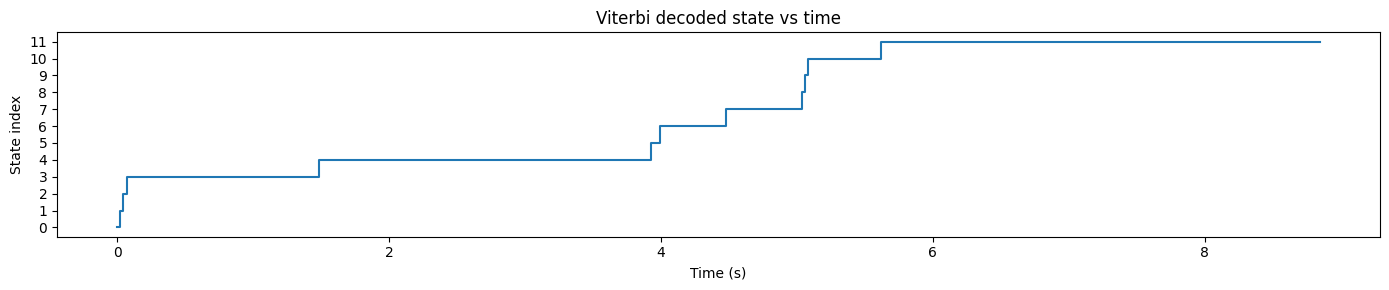

In [38]:
plot_state_path(path, sr, hop_length)